In [8]:
%matplotlib inline

import numpy as np

from matplotlib import pyplot as plt
import os
import glob as glob
import pandas as pd
import time
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
# sys.path.insert(0,'/global/cscratch1/sd/bpb/repos/simile')
sys.path.insert(0,'/global/homes/b/bpb/repos/blink')
import blink
from scipy.cluster.hierarchy import linkage, dendrogram
import skbio

from pyteomics import mgf
import numpy as np
import scipy.sparse as sp
import networkx as nx

from rdkit.Chem import InchiToInchiKey
# from sklearn.cluster import DBSCAN
import markov_clustering as mc

import time

In [18]:
spectra['metadata'][0]

{'pepmass': (174.088, None),
 'charge': [1],
 'mslevel': '2',
 'source_instrument': 'LC-ESI-Orbitrap',
 'filename': 'test.mgf',
 'seq': '*..*',
 'ionmode': 'Negative',
 'organism': 'BERKELEY-LAB',
 'name': 'L-citrulline M-H',
 'pi': 'Trent Northen',
 'datacollector': 'JGI:192022',
 'smiles': 'N=C(O)NCCC[C@H](N)C(=O)O',
 'inchi': 'InChI=1S/C6H13N3O3/c7-4(5(10)11)2-1-3-9-6(8)12/h4H,1-3,7H2,(H,10,11)(H3,8,9,12)/t4-/m0/s1',
 'inchiaux': 'N/A',
 'pubmed': 'N/A',
 'submituser': 'mpanitchpakdi',
 'libraryquality': '3',
 'spectrumid': 'CCMSLIB00006685342',
 'scans': '1',
 'precursor_mz': 174.088}

CPU times: user 4.7 s, sys: 28.3 ms, total: 4.73 s
Wall time: 4.76 s


In [23]:
big_start_time = time.time()

start_time = time.time()
file='/global/cfs/cdirs/metatlas/projects/spectral_libraries/BERKELEY-LAB.mgf'
# compound_file='/global/cfs/cdirs/metatlas/projects/unique_compounds.csv.gz'
spectra = blink.open_msms_file(file)
spectra = spectra[spectra['ionmode']=='Positive']
# spectra = spectra[spectra['name'].str.contains('phenyl')]
# spectra = spectra[spectra['name'].str.endswith('M+H')]
# spectra.drop_duplicates('name',inplace=True)
spectra['inchi_key'] = spectra['inchi'].apply(lambda x: InchiToInchiKey(x))
spectra['num_ions'] = spectra['spectrum'].apply(lambda x: len(x[0]))
# cpds = pd.read_csv(compound_file,usecols=['inchi_key','inchi','name','mono_isotopic_molecular_weight'])
# cpds.index.name='id'
# cpds.reset_index(drop=False,inplace=True)
# spectra = pd.merge(spectra,cpds[['id','inchi_key']],left_on='inchi_key',right_on='inchi_key',how='left')
spectra = blink.discretize_spectra(spectra['spectrum'].tolist(),
                               pmzs=spectra['precursor_mz'].tolist(),
                               remove_duplicates=False,
                               metadata=spectra.drop(columns=['spectrum']).to_dict(orient='records'))
print('Convert raw spectra into sparse BLINK format took %.2f seconds\n'%(time.time()-start_time))


start_time = time.time()
blink_score = blink.score_sparse_spectra(spectra, spectra)
print('Calciulation of BLINK scores took %.2f seconds\n'%(time.time()-start_time))

start_time = time.time()
blink_score = blink.filter_hits(blink_score,min_matches=5,good_matches=20000,good_score=0.01,calc_network_score=True)
print('filtering blink took %.2f seconds\n'%(time.time()-start_time))

start_time = time.time()
# n = blink_score['mzi'].tocsr()
n = blink_score['network_score'].tocsr()
n.setdiag(0)
n.eliminate_zeros()
print('blink score to csr took %.2f seconds\n'%(time.time()-start_time))

start_time = time.time()
result = mc.run_mcl(n,inflation=2)           # run MCL with default parameters
clusters = mc.get_clusters(result)    # get clusters
labels = np.zeros((n.shape[0]))
for i,c in enumerate(clusters):
    for g in c:
        labels[g] = i
print('run mcl took %.2f seconds\n'%(time.time()-start_time))

start_time = time.time()
n[n>1] = 1
n[n.nonzero()] = 1 - n[n.nonzero()]
from scipy.sparse.csgraph import minimum_spanning_tree
n = minimum_spanning_tree(n)
G = nx.from_scipy_sparse_matrix(n)
print('reversing scores and making minimum spanning tree took %.2f seconds\n'%(time.time()-start_time))

print('Overall block time took %.2f seconds\n'%(time.time()-big_start_time))



Convert raw spectra into sparse BLINK format took 12.70 seconds

Calciulation of BLINK scores took 20.96 seconds

filtering blink took 56.69 seconds

blink score to csr took 1.08 seconds

run mcl took 370.46 seconds

reversing scores and making minimum spanning tree took 9.12 seconds

Overall block time took 471.00 seconds



In [25]:
len(spectra['metadata'])

14969

In [6]:
# for inflation in np.linspace(1.5,4,10):
#     result = mc.run_mcl(n, inflation=inflation)
#     clusters = mc.get_clusters(result)
#     Q = mc.modularity(matrix=result, clusters=clusters)
#     print("inflation:", inflation, "modularity:", Q)

# Graph layout

In [11]:
pos = nx.nx_agraph.graphviz_layout(G, prog="neato")


# draw graph

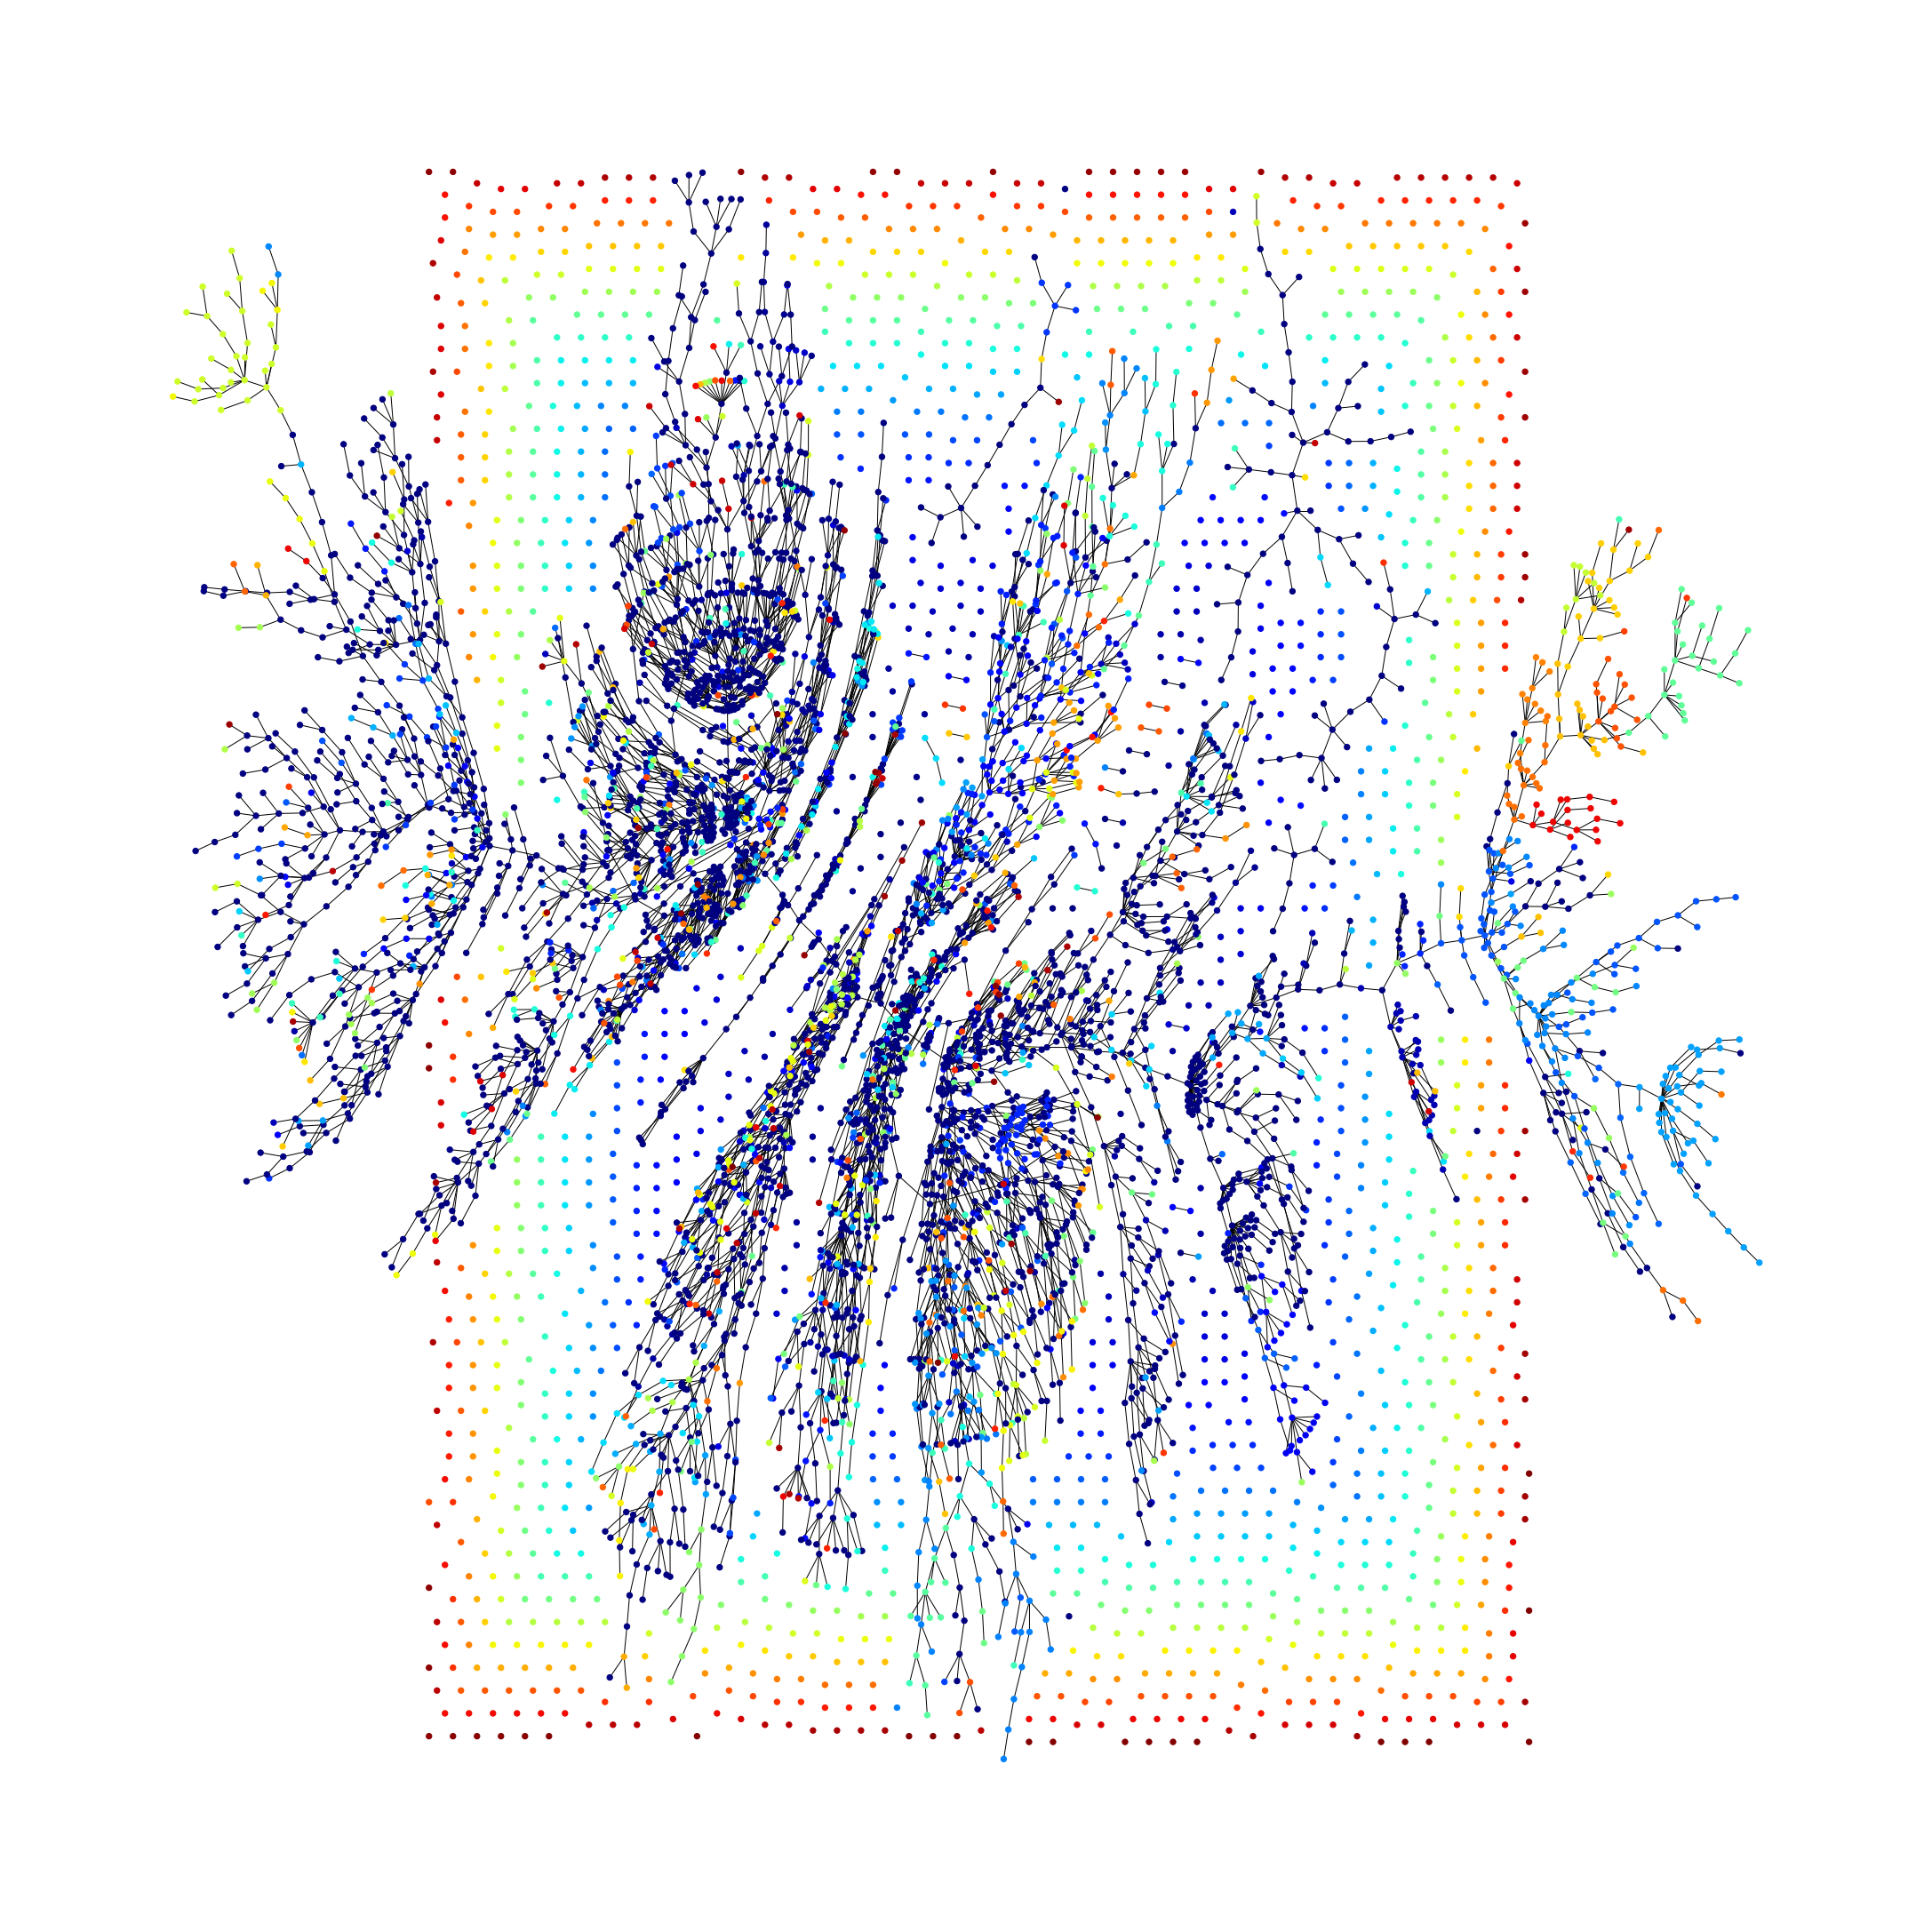

In [12]:

# pos = nx.spring_layout(G,)
fig = plt.figure(figsize=(30,30))

    
nx.draw(G, pos, node_size=40, node_color=labels, with_labels=False,cmap='jet')

In [13]:
fig.savefig('mst_blink_mcl_berklab-df.pdf')

In [14]:
d = n.todense()

d[5,6]

df = pd.DataFrame(spectra['metadata'])
# cols = ['name', 'precursor_mz', 'inchi_key', 'num_ions', 'id']
cols = ['ionmode',  'name',  'smiles', 'inchi', 'spectrumid',
       'scans', 'precursor_mz', 'inchi_key', 'num_ions', 'id']
df = df[cols]

df['cluster']  = labels
# df.sort_values('cluster',inplace=True)
# node_attr = df_attributes_only.to_dict('index')
nx.set_node_attributes(G, df.to_dict('index'))
df.head(20)

,ionmode,name,smiles,inchi,spectrumid,scans,precursor_mz,inchi_key,num_ions,id,cluster
0,Positive,L-citrulline M+H,N=C(O)NCCC[C@H](N)C(=O)O,InChI=1S/C6H13N3O3/c7-4(5(10)11)2-1-3-9-6(8)12...,CCMSLIB00006685789,448,176.103,RHGKLRLOHDJJDR-BYPYZUCNSA-N,21,1437,0.0
1,Positive,L-proline M+H,O=C(O)[C@@H]1CCCN1,"InChI=1S/C5H9NO2/c7-5(8)4-2-1-3-6-4/h4,6H,1-3H...",CCMSLIB00006685790,449,116.071,ONIBWKKTOPOVIA-BYPYZUCNSA-N,9,117405,1.0
2,Positive,L-serine M+H,N[C@@H](CO)C(=O)O,"InChI=1S/C3H7NO3/c4-2(1-5)3(6)7/h2,5H,1,4H2,(H...",CCMSLIB00006685791,450,106.050,MTCFGRXMJLQNBG-REOHCLBHSA-N,10,26805,2.0
3,Positive,L-methionine M+H,CSCC[C@H](N)C(=O)O,"InChI=1S/C5H11NO2S/c1-9-3-2-4(6)5(7)8/h4H,2-3,...",CCMSLIB00006685792,451,150.058,FFEARJCKVFRZRR-BYPYZUCNSA-N,22,24454,3.0
4,Positive,L-asparagine M+H,N=C(O)C[C@H](N)C(=O)O,"InChI=1S/C4H8N2O3/c5-2(4(8)9)1-3(6)7/h2H,1,5H2...",CCMSLIB00006685793,452,133.061,DCXYFEDJOCDNAF-REOHCLBHSA-N,13,23967,4.0
5,Positive,L-phenylalanine M+H,N[C@@H](Cc1ccccc1)C(=O)O,InChI=1S/C9H11NO2/c10-8(9(11)12)6-7-4-2-1-3-5-...,CCMSLIB00006685794,453,166.086,COLNVLDHVKWLRT-QMMMGPOBSA-N,17,24440,5.0
6,Positive,biotin M+H,O=C(O)CCCC[C@@H]1SC[C@@H]2N=C(O)N[C@H]12,InChI=1S/C10H16N2O3S/c13-8(14)4-2-1-3-7-9-6(5-...,CCMSLIB00006685795,454,245.095,YBJHBAHKTGYVGT-ZKWXMUAHSA-N,84,112402,5.0
7,Positive,biotin 2M+H,O=C(O)CCCC[C@@H]1SC[C@@H]2N=C(O)N[C@H]12,InChI=1S/C10H16N2O3S/c13-8(14)4-2-1-3-7-9-6(5-...,CCMSLIB00006685796,455,489.184,YBJHBAHKTGYVGT-ZKWXMUAHSA-N,21,112402,5.0
8,Positive,biotin M+Na,O=C(O)CCCC[C@@H]1SC[C@@H]2N=C(O)N[C@H]12,InChI=1S/C10H16N2O3S/c13-8(14)4-2-1-3-7-9-6(5-...,CCMSLIB00006685797,456,267.077,YBJHBAHKTGYVGT-ZKWXMUAHSA-N,16,112402,6.0
9,Positive,biotin M+K,O=C(O)CCCC[C@@H]1SC[C@@H]2N=C(O)N[C@H]12,InChI=1S/C10H16N2O3S/c13-8(14)4-2-1-3-7-9-6(5-...,CCMSLIB00006685798,457,283.051,YBJHBAHKTGYVGT-ZKWXMUAHSA-N,16,112402,7.0


In [15]:
nx.write_graphml(G,'mst_blink_mcl_berklab.graphml')